/tmp/ipykernel_832641/575176912.py:29: RuntimeWarning: invalid value encountered in double_scalars
  z[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])
/tmp/ipykernel_832641/575176912.py:31: RuntimeWarning: invalid value encountered in divide
  z[w] = (y[w+1]-y[w-1])/(x[w+1]-x[w-1])
/tmp/ipykernel_832641/575176912.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  z[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])
/tmp/ipykernel_832641/575176912.py:31: RuntimeWarning: divide by zero encountered in divide
  z[w] = (y[w+1]-y[w-1])/(x[w+1]-x[w-1])
/tmp/ipykernel_832641/575176912.py:122: RuntimeWarning: invalid value encountered in sqrt
  Ldiff = np.sqrt(nu*deltat)
/tmp/ipykernel_832641/575176912.py:133: RuntimeWarning: invalid value encountered in sqrt
  Ldiff_corr = np.sqrt(nu*deltat * factors)
/tmp/ipykernel_832641/575176912.py:161: RuntimeWarning: invalid value encountered in log10
  y_geom = np.log10(deltat/(3*rho*Lgeom**2))
/tmp/ipykernel_832641/575176912.py:167: RuntimeWarning: invalid value e

r=0: 
 log Ldiff/Lgeom = [5.77663581] ; log Ldiff/Lp = [6.54838204] ; log10(vdiff/v)= [5.58697668]
end phase 3: 
 Ldiff/Lgeom = 6.070112829729639 ; log Ldiff/Lp = 7.705558963387181 ; log10(vdiff/v)= 6.69492229081245
ratios: 
 Lgeom = [1.05080414] ; Lp = [1.17671188] ; v = [1.19830862]
collision radius = 1.8606171866456034 ; collision time = 0.15991071132940227


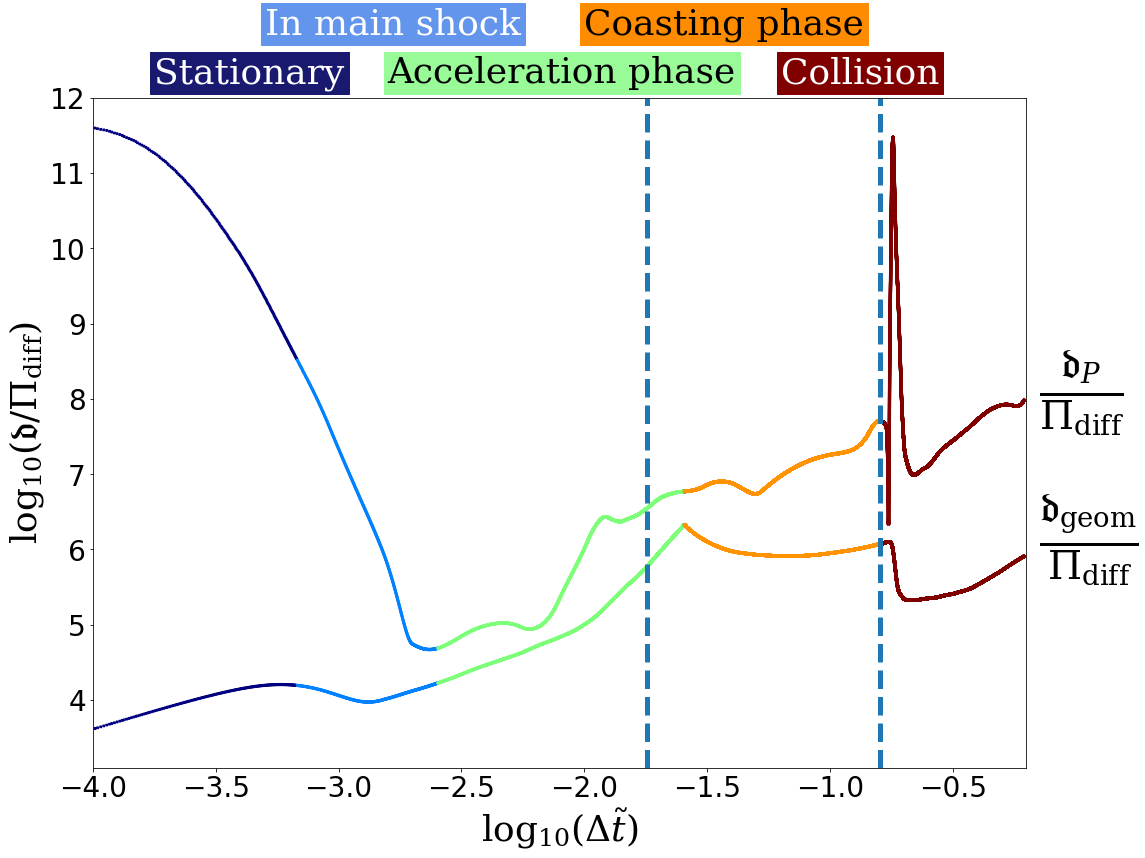

In [108]:
import numpy as np
# import matplotlib.pyplot as plt
import matplotlib 
import matplotlib.patches as mpatches
from scipy.interpolate import splrep, BSpline
from scipy.interpolate import interp1d as intp
from scipy import signal
import scipy.integrate as si
import pylab as plt
params = {'mathtext.fontset': 'dejavuserif'}
plt.rcParams.update(params)
%matplotlib inline



def integrate2(x,y):
    ''' integrate2 is cumulative integral(y)dx formatted as [0, cumtrapz(y,x)]: same size as input. ''' 
    return np.hstack([0,si.cumtrapz(y,x)])
    #return si.cumtrapz(y,x)    
    
def integral2(x,y):
    ''' integral2 is total integral(y)dx computed using trapz(y,x). Consider using simps instead. ''' 
    return si.trapz(y,x) 

def mydiff(x,y):
    ''' mydiff(x,y) returns second-order difference dy/dx except at ends (1st-order): same size as input. ''' 
    z = y*0.
    z[0] = (y[1]-y[0])/(x[1]-x[0])
    z[-1] = (y[-1]-y[-2])/(x[-1]-x[-2])
    w = np.arange(1,len(z)-1)
    z[w] = (y[w+1]-y[w-1])/(x[w+1]-x[w-1])
    return z

def smooth(f, width):
    t_kernel = np.linspace(-3*width,3*width,6*width+1)  # t values for defining kernel
    kernel = np.exp(-(t_kernel/width)**2)  # Gaussian out to 3 widths each direction
    return signal.fftconvolve(f, kernel, mode='same') / signal.fftconvolve(f*0+1., kernel, mode='same')
    

# plt.style.use(["presentation"])  # a set of rules to make plots presentable by default (large font, etc.)
# (requires special matplotlib style file. see: 
#     https://matplotlib.org/stable/tutorials/introductory/customizing.html#using-style-sheets )


# f = open("../../project_1/big_runs/round_6/coy_3/energy.txt")
f = open("../../project_1/big_runs/round_6/coy_3/energy.txt")
E_ = float(f.read())
f.close()
M_ = 3.08507687
R_ = 1
rho_ = M_/R_**3
v_=(E_/M_)**(1/2)
t_ = R_/v_
P_ = E_/R_**3

# filename = r'../../project_1/big_runs/round_7/hom_lowering/tracked_cell_43_97.txt'
filename = r'../../project_1/big_runs/round_6/coy_3/tracked_cell_40_97.txt'
idx, t, x, y, vx,vy,rho, P = np.loadtxt(filename,delimiter=',').transpose()

# Scaling
P = P/P_
rho = rho/rho_
t = t/t_
vx = vx/v_
vy = vy/v_

vx_roll = np.roll(vx,1)
roll_idx = np.where(vx != vx_roll)
t_new = t[roll_idx]


tck_x = splrep(t, vx, s=15)
tck_y = splrep(t, vy, s=15)
vx_s = BSpline(*tck_x)(t)
vy_s = BSpline(*tck_y)(t)


# code properties 
E = E_
dr0 = .0025 # initial res: 1/200. 


r = np.sqrt(x**2+y**2)

# characteristic length scale: max of (initial depth, current distance from surface)
Lgeom = np.maximum(np.abs(r-1), 1-r[0])  

# another characteristic length scale: pressure scale height L_p =  P/|grad P| 
# which we can evaluate from    rho a = - grad(P)
#                      so P/|grad(P)| = |P/(rho*a)| 
# so start by obtaining acceleration field

ax_s = mydiff(t, vx_s)
ay_s = mydiff(t, vy_s)
ax = mydiff(t,vx)
ay = mydiff(t,vy)

a = np.sqrt(ax_s**2 + ay_s**2)
# a = np.sqrt(ax**2 + ay**2)

a_idx = np.where(np.diff(a)<=4.6)
# Lp = P/(rho*a0)
Lp = P/(rho*a)

v = np.sqrt(vx**2+vy**2)
distance = np.sqrt((x-x[0])**2 + (y-y[0])**2)
dist_idx = distance

gamma = 4./3
s = P/rho**gamma


# estimate when the cell is hit, define as t0
t0a = np.max(t[(s<.01)]); 
t0b = np.min(t[(s>.01)]);
t0 = np.mean((t0a,t0b));
deltat = t - t0
c,kappa = 1.,1. # placeholder definitions to keep expressions physical. 

nu = c/(3*kappa*rho)  # diffusivity 
# use diffusivity to get instaneous estimate of the diffusion length
Ldiff = np.sqrt(nu*deltat)
vdiff = nu/Lp  # local estimate of diffusion speed of energy though fluid.  
    # note, vdiff/v = nu/(Lp v) is like 1/(Reynolds number)

# this can be improved using the history of the diffusivity...  start calc only when shock arrives
w = deltat>0
factor = integrate2(deltat[w],rho[w]**(-1./3))/(deltat[w]*rho[w]**(-1./3))
# 'factor' is a correction factor to account for past variations of nu because of changes in rho. 
#... incorporate this into a correction factor that is 1 before the shock arrives. 
factors = t*0+1.; factors[w]=factor;  
# and use this to make a corrected version of the diffusion length 
Ldiff_corr = np.sqrt(nu*deltat * factors)


# Define masks for the phases of evolution 0-4: 
w0 = (distance<.1*dr0)
w0i = (dist_idx<.1*dr0)
w1 = (~w0)*(distance<3*dr0)#*(t<max(t[a>max(a)/2])) 
w1i = (~w0i)*(dist_idx<3*dr0)
w2 = (~w0)*(~w1)*(np.abs(r-1) < 1-r[0])
w2i = (~w0i)*(~w1i)*(np.abs(r-1) < 1-r[0])
w3 = (~w0)*(~w1)*(~w2)*(vy_s<0) * (t<(min(t[vy_s==min(vy_s)]) ) )
w3i = (~w0i)*(~w1i)*(~w2i)*(vy_s<0) * (t<(min(t[vy_s==min(vy_s)]) ) )
w4 = (~w0)*(~w1)*(~w2)*(~w3)
w4i = (~w0i)*(~w1i)*(~w2i)*(~w3i)
which = t*0-1; 
which[w0]=0
which[w1]=1
which[w2]=2
which[w3]=3
which[w4]=4


fig = plt.figure(figsize=(16,12))
axs = plt.subplot(111)
# Plot diffusion properties in each phase, and report on the comparison between the middle of phase 2 and the end of phase 3: 
cmp = 'jet'

# y_geom = np.log10(Ldiff**2*R_**2/(Lgeom**2*np.sqrt(E_*M_)))
y_geom = np.log10(deltat/(3*rho*Lgeom**2))
geom_p = np.roll(y_geom, 1)
geom_m = np.roll(y_geom, -1)
idx1 = np.where((np.abs(y_geom-geom_p)<0.25) & (np.abs(y_geom-geom_m)<0.25))

# y_p = np.log10(Ldiff**2*R_**2/(Lp**2*np.sqrt(E_*M_)))
y_p = np.log10(deltat/(3*rho*Lp**2))
p_p = np.roll(y_p, 1)
p_m = np.roll(y_p, -1)
idx2 = np.where((np.abs(y_p-p_p)<0.25) & (np.abs(y_p-p_m)<0.25))

y_pmax = np.amax(y_p[w3])
max_idx = np.where(y_p==y_pmax)[0][0]

w3_start = np.where(w3)[0][0]
w4_end = np.where(w4)[0][-1]
which[w3_start:max_idx]=3
which[max_idx:w4_end]=4


font = {'fontname':'serif'}

axs.scatter(np.log10(deltat[idx1]), y_geom[idx1], c=which[idx1], s=5, marker='x', cmap=cmp)
# axs.scatter(np.log10(deltat), np.log10(Ldiff/Lgeom), c=which, s=5, marker='x', cmap=cmp)
#axs.scatter(np.log10(deltat), np.log10(Ldiff_corr/Lgeom), c=which, s=0.5, alpha=0.5, cmap=cmp)


axs.scatter(np.log10(deltat[idx2]), y_p[idx2],s=5, c=which[idx2], marker='x', cmap=cmp)
# axs.scatter(np.log10(deltat), np.log10(Ldiff/Lp),s=5, c=which, marker='x', cmap=cmp)
# axs.scatter(np.log10(deltat), np.log10(Ldiff_corr/Lp),s=0.5, c=which, alpha=0.5, cmap=cmp)


# axs.scatter(np.log10(deltat), np.log10(vdiff/v), c=which, s=5, alpha=0.5, cmap=cmp)

#axs.plot(np.log10(deltat), np.log10(s),':y', linewidth=0.5) 

wr0 = (np.abs(1-r) == min(np.abs(1-r) ) )
wr0i = (np.abs(1-r) == min(np.abs(1-r)) )
# wEnd3 = (t == max(t[w3]))
# wEnd3i = (t == max(t[w3i]))
wEnd3 = max_idx
wEnd3i = max_idx
print('r=0: \n log Ldiff/Lgeom =',y_geom[wr0], 
      '; log Ldiff/Lp =',y_p[wr0i],
      '; log10(vdiff/v)=', np.log10(vdiff[wr0i]/v[wr0]))
print('end phase 3: \n Ldiff/Lgeom =',y_geom[wEnd3],
      '; log Ldiff/Lp =',y_p[wEnd3i],
      '; log10(vdiff/v)=', np.log10(vdiff[wEnd3i]/v[wEnd3]))
print('ratios: \n Lgeom =', y_geom[wEnd3]/y_geom[wr0], '; Lp =', 
      y_p[wEnd3i]/y_p[wr0i], '; v =',
      np.log10(vdiff[wEnd3i]/v[wEnd3])/np.log10(vdiff[wr0i]/v[wr0]))
#print(deltat[wr0], (np.log10(deltat[wr0]), np.log10(deltat[wEnd3])) ) 
print("collision radius =", r[wEnd3], '; collision time =', deltat[wEnd3])

lbl_sz = 36
axs.annotate("Stationary", (-3.75,12.2), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='midnightblue', color="w", **font)
axs.annotate("In main shock", (-3.3,12.85), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='cornflowerblue', color="w", **font)
axs.annotate("Acceleration phase", (-2.8,12.2), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='palegreen', color="k", **font)
axs.annotate("Coasting phase", (-2.,12.85), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='darkorange', color="k", **font)
axs.annotate("Collision", (-1.2,12.2), annotation_clip=False, 
            fontsize=lbl_sz, backgroundcolor='maroon', color="w", **font)

axs.annotate

eq_sz = 56
fs = 28
# axs.annotate(r"$\frac{\mathfrak{d}_{{\rm geom}}}{\Pi_{\rm diff}}$", (-0.15, 5.9), 
#             annotation_clip=False, fontsize=eq_sz, **font)
# axs.annotate(r"$\frac{\mathfrak{d}_{P}}{\Pi_{\rm diff}}$", (-0.15, 7.9), 
#             annotation_clip=False, fontsize=eq_sz, **font)
axs.text(-0.15, 5.9, r"$\frac{\mathfrak{d}_{{\rm geom}}}{\Pi_{\rm diff}}$", 
            fontsize=eq_sz, **font)
axs.text(-0.15, 7.9, r"$\frac{\mathfrak{d}_{P}}{\Pi_{\rm diff}}$",
            fontsize=eq_sz, **font)


ln_w = 5
axs.axvline(np.log10(deltat[wr0]), linestyle='--', linewidth=ln_w) 
# axs.axvline(np.log10(deltat[wEnd3]), linestyle='--', linewidth=ln_w)
axs.axvline(np.log10(deltat[max_idx]), linestyle='--', linewidth=ln_w)

axs.set_xlabel(r"$\log_{10}(\Delta \tilde{t})$", fontsize=lbl_sz, **font)
axs.set_ylabel(r"$\log_{10}(\mathfrak{d}/\Pi_{\rm diff})$", fontsize=lbl_sz, **font)
axs.tick_params(labelsize=fs)
axs.set_ylim(3.1,12)
axs.set_xlim(-4,-0.2)
# axs.set_title("$\mathcal{D}$ parameters")
plt.tight_layout()
plt.savefig("anl_plot.png")
plt.show()


Text(1.9, 3, '$\\frac{\\mathfrak{d}_{\\rm geom}}{{\\Pi}_{\\rm diff}}$')

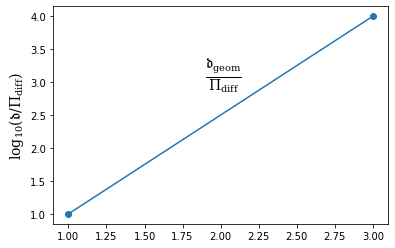

In [73]:
import pylab as plt
params = {'mathtext.fontset': 'dejavuserif'}
plt.rcParams.update(params)
%matplotlib inline
plt.plot([1,3],[1,4],'o-')

plt.ylabel(r'${\log_{10}(\mathfrak{d}}/{\Pi_{\rm diff}})$',fontsize=14)
plt.text(1.9,3,r'$\frac{\mathfrak{d}_{\rm geom}}{{\Pi}_{\rm diff}}$', fontsize=20)

In [95]:
A = np.array([0,1,2,3,4,5,6,7,8,9])
B = [0,1,2,3,4]
print(A[B[0]:6])

[0 1 2 3 4 5]
